<a href="https://colab.research.google.com/github/mluppichini/CleverRiver/blob/main/CleverRiver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='top'></a>

# **CleverRiver**: an introduction

CleverRiver is a Google Colab workflow to train deep learning models for the prediction of river flow. 

CleverRiver is developed by [Marco Luppichini](https://orcid.org/0000-0002-0913-3825), [Monica Bini](https://orcid.org/0000-0003-1482-2630) and [Roberto Giannecchini](https://orcid.org/0000-0003-0447-3086) of the Earth Sciences Department of the University of Pisa, Italy. 

version: 1.0 <br>
release date: 2022-07-12
<br>
<br>
The worflow is composed by three sections:
> Section I: in this section is possible to train deep learning models using different archictectures and export of the results

> Section II: in this section is possible to create predictions and displaing the results with graphs and csv files

> Section III: in this section is possible to send reports and suggestions to the research group








<a id='sectionI'></a>
# **Section I**



##**Step 1.1**: Set the workspace
creation of the **workspace** and the **directory** and import of the needed **libraries**



In [ ]:
#@markdown Execute Step 1.1
import matplotlib.pyplot as plt
from matplotlib.patches import *
import numpy as np
import pandas as pd
import os
import sys
import datetime
from datetime import timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import LeakyReLU, RNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History, ModelCheckpoint
from time import time
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras import callbacks
from tensorflow.keras.models import model_from_json
import keras
from math import sqrt
import shutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import json

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

def save_deep_learning_model(model, output_model_json, save_weights = False):
    model_json = model.to_json()
    with open(output_model_json, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    if save_weights == True:
        output_model_h5 = output_model_json.replace(".json", ".h5")
        model.save_weights(output_model_h5)

def add_pre_post_series(df, n_step_back,step_t, n_step_forward):
    df = df.copy()
    if n_step_back >= 4:
        n_step_back_res = 5
    else:
        n_step_back_res = n_step_back
    for column in df.columns:
        if column != "datetime":
            for gg in range(1, n_step_back_res, 1):
                nome_col_day = "%s_%s" % (column, gg)
                df[nome_col_day] = df[column].shift(gg)
            for gg in range(n_step_back_res + step_t - 1, n_step_back, step_t):
                nome_col_day = "%s_%s" % (column, gg)
                df[nome_col_day] = df[column].shift(gg)
        if "output" in column:
            for gg in range(1, n_step_forward):
                nome_col_day = "%s_%soutput_after" % (column, gg)
                df[nome_col_day] = df[column].shift(-gg)
    return df


def LEARNING_MODEL(df_tot, 
                   cnn_n_node, lstm_n_node,
                  patience,
                  folder_model_out ,
                  date_max_train,
                  date_max_validation,
                  model_type,
                  forcasting,
                   optimizer,
                   loss_function
                  ):

    
    if not os.path.isdir(folder_model_out): os.mkdir(folder_model_out)
    folder_scatter_out = os.path.join(folder_model_out, 'scatters')
    if not os.path.isdir(folder_scatter_out): os.mkdir(folder_scatter_out)
    folder_history_out = os.path.join(folder_model_out, 'history')
    if not os.path.isdir(folder_history_out): os.mkdir(folder_history_out)
    folder_time_out = os.path.join(folder_model_out, 'time')
    if not os.path.isdir(folder_time_out): os.mkdir(folder_time_out)

    colonna_output = 'output'
    df_tot = df_tot.sort_values('datetime')

    if forcasting > 0:
      df_tot[colonna_output] = df_tot[colonna_output].shift(-forcasting)
    df_tot = df_tot.dropna()
    #TRAIN
    dfTrain = df_tot[df_tot['datetime'] <= date_max_train]
    X_train = dfTrain.drop([colonna_output, 'datetime'], axis=1).values
    y_train = dfTrain[colonna_output].values

    #VALIDATION
    dfVal = df_tot[(df_tot['datetime'] > date_max_train) & (df_tot['datetime'] <= date_max_validation)]
    X_val = dfVal.drop([colonna_output, 'datetime'], axis=1).values
    y_val = dfVal[colonna_output].values

    #TEST
    dfTest = df_tot[df_tot['datetime'] > date_max_validation]
    X_test = dfTest.drop([colonna_output, 'datetime'], axis=1).values
    y_test = dfTest[colonna_output].values

    bst_model_path = folder_model_out + os.sep + "%st.h5" % (forcasting)
    bst_model_path_json = folder_model_out + os.sep + "%st.json" % (forcasting)

    # if not os.path.isfile(folder_model_out + os.sep + "Test.csv"):
    #     dfTest.to_csv(folder_model_out + os.sep +   "Test.csv", index=False)
    # if not os.path.isfile(folder_model_out + os.sep   + "_Train.csv"):
    #     dfTrain.to_csv(folder_model_out + os.sep   + "_Train.csv", index=False)
    # if not os.path.isfile(folder_model_out + os.sep   + "_Val.csv"):
    #     dfVal.to_csv(folder_model_out + os.sep   + "_Val.csv", index=False)
    
    if model_type == 'CNN-LSTM':
        model, X_train2, X_test2,y_train2, y_test2, history = LearningModelCNNLSTM(X_train, X_val, y_train, y_val, bst_model_path, bst_model_path_json, patience, cnn_n_node, lstm_n_node, optimizer, loss_function)
    elif model_type == 'LSTM-ED':
        model, X_train2, X_test2,y_train2, y_test2, history = LearningModelLSTMED(X_train, X_val, y_train, y_val, bst_model_path, bst_model_path_json, patience, lstm_n_node, optimizer, loss_function)
    elif model_type == 'LSTM':
        model, X_train2, X_test2, y_train2, y_test2, history = LearningModelLSTM(X_train, X_val, y_train, y_val,
                                                                                  bst_model_path,
                                                                                 bst_model_path_json, patience,
                                                                                   lstm_n_node, optimizer, loss_function)
    if 'CNN-LSTM' == model_type:
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    elif 'LSTM' == model_type:
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    elif 'LSTM-ED' == model_type:
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    #X_test = X_test.reshape((X_test.shape[0], 2, 2, 1))
    yhat = model.predict(X_test.astype(np.float32), verbose=0)

   
   # if  model_type == 'LSTM-ED': yhat = [i[0][0] for i in yhat ]
    
    dfPred = pd.DataFrame()
    dfPred['datetime'] = dfTest['datetime'].values
    dfPred['observed'] = dfTest[colonna_output].values
    dfPred['predicted'] = yhat
    dfPred.to_csv(folder_model_out +os.sep+ str(forcasting) +"_predicted.csv", index = False)

    # calculate RMSE
    rmse = sqrt(mean_squared_error(y_test, yhat))
    r2 = r2_score(y_test, yhat)
    mae= mean_absolute_error(y_test, yhat)
    print ("RMSE", rmse)
    print ("R2", r2)

    n_epoche = len(history.epoch)

    figure, ax = plt.subplots()
    ax.set_xlabel("observed", fontsize=16)
    ax.set_ylabel("predicted", fontsize=16)
    ax.scatter(y_test, yhat)
    ax.plot(y_test, y_test, color="red")
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)
    figure.set_figheight(8)
    figure.set_figwidth(8)
    figure.savefig(folder_scatter_out + os.sep + str(forcasting) + "t.png", dpi=90)
    plt.close()

    figure, ax = plt.subplots()
    ax.set_xlabel("epoch", fontsize=16)
    ax.set_ylabel("loss", fontsize=16)
    ax.plot(history.history['loss'], label = "loss")
    ax.plot(history.history['val_loss'], label = "val_loss")
    ax.legend()
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)
    figure.set_figheight(8)
    figure.set_figwidth(8)
    figure.savefig(folder_history_out + os.sep + str(forcasting) + "t.png",
                    dpi=90)
    plt.close()

    figure, ax = plt.subplots()
    ax.set_xlabel("time", fontsize=16)
    
    pass_timeDelta = dfTest['datetime'].iloc[1] - dfTest['datetime'].iloc[0]
    delta = timedelta(days=pass_timeDelta.days)
    ax.plot(dfTest['datetime'] + delta * forcasting, y_test, label="test")
    ax.plot(dfTest['datetime'] + delta * forcasting, yhat, label="predicted")
    ax.legend()
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0, hspace=0)
    figure.set_figheight(6)
    figure.set_figwidth(10)
    figure.savefig(folder_time_out + os.sep +  str(forcasting) + "t.png",
                    dpi=90)
    plt.close()

    df = pd.DataFrame()
    df['Number of CNN nodes'] = [cnn_n_node]
    df['Number of LSTM nodes'] = [lstm_n_node]
    df['Number of epochs'] = [n_epoche]
    df['RMSE'] = [rmse]
    df['R2'] = [r2]
    df['MAE'] = [mae]
    df['Lenght of dataset'] = len(df_tot)
    df['Length of train dataset'] = X_train.shape[0]
    df['Length of validation dataset'] = X_val.shape[0]
    df['Length of test dataset'] = X_test.shape[0]
    df.to_csv(folder_model_out +os.sep+ str(forcasting) +"t_metrics.csv", index = False)
    plt.close()


def LearningModelCNNLSTM(X_train, X_test, y_train, y_test, bst_model_path, bst_model_path_json, patience, cnn_n_node, lstm_n_node, optimizer, loss_function):
    n_features = 1

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

    # design network
    rmse_lis, r2_list, number_nodi, n_epoche = [], [], [], []
    earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                            mode="min", patience=patience,
                                            restore_best_weights=True)

    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

    model = Sequential()
    model.add(Conv1D(filters=cnn_n_node, kernel_size=2, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Conv1D(filters=cnn_n_node * 2, kernel_size=2))
    model.add(MaxPooling1D(pool_size=1))
    model.add(LSTM(lstm_n_node))
    model.add(Flatten())
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer=optimizer.lower(), loss=loss_function.lower())
    model.summary()
    history = model.fit(X_train.astype(np.float32), y_train.astype(np.float32), epochs=10000, batch_size= 70*24*4,
                        validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)), verbose=0,
                        shuffle=False, validation_split=0, callbacks=[earlystopping, model_checkpoint])

    model.load_weights(bst_model_path)
    save_deep_learning_model(model, bst_model_path_json, False)
    keras.backend.clear_session()
    return model, X_train, X_test, y_train, y_test, history


def LearningModelLSTMED(X_train, X_test, y_train, y_test, bst_model_path, bst_model_path_json, patience, lstm_n_node, optimizer, loss_function):
    n_features = 1
    X_train = X_train.reshape((X_train.shape[0],  n_features, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], n_features,  X_test.shape[1]))

    # design network
    rmse_lis, r2_list, number_nodi, n_epoche = [], [], [], []
    earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                            mode="min", patience=patience,
                                            restore_best_weights=True)

    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)


    model = Sequential()
    #Encoder
    model.add(LSTM(lstm_n_node, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(int(lstm_n_node/2), activation='relu', return_sequences=False))
    model.add(RepeatVector(X_train.shape[1]))
    model.add(LSTM(int(lstm_n_node/2), activation='relu', return_sequences=True))
    model.add(LSTM(lstm_n_node, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.add(Flatten())
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer=optimizer.lower(), loss= loss_function.lower())
    
    model.summary()
    history = model.fit(X_train.astype(np.float32), y_train.astype(np.float32), epochs=10000, batch_size=70*24*4,
                        validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)), verbose=0,
                        shuffle=False, validation_split=0, callbacks=[earlystopping, model_checkpoint])

    model.load_weights(bst_model_path)
    save_deep_learning_model(model, bst_model_path_json, False)
    keras.backend.clear_session()
    return model, X_train, X_test, y_train, y_test, history


def LearningModelLSTM(X_train, X_test, y_train, y_test, bst_model_path, bst_model_path_json, patience, lstm_n_node, optimizer, loss_function):
    n_features = 1
    X_train = X_train.reshape((X_train.shape[0],  n_features, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], n_features,  X_test.shape[1]))

    # design network
    rmse_lis, r2_list, number_nodi, n_epoche = [], [], [], []
    earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                            mode="min", patience=patience,
                                            restore_best_weights=True)

    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

    model = Sequential()
    model.add(LSTM(lstm_n_node, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Flatten())
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer=optimizer.lower(), loss=loss_function.lower())
    model.summary()
    history = model.fit(X_train.astype(np.float32), y_train.astype(np.float32), epochs=10000, batch_size=70*24*4,
                        validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)), verbose=0,
                        shuffle=False, validation_split=0, callbacks=[earlystopping, model_checkpoint])

    model.load_weights(bst_model_path)
    save_deep_learning_model(model, bst_model_path_json, False)
    keras.backend.clear_session()
    return model, X_train, X_test, y_train, y_test, history


folder_input = "/content/training_input_data/"
folder_output = "/content/trained_models/"
file_zip_out = "/content/LearningModels"
file_output = 'output.csv'
columns = ['datetime', 'value']
col_out = 'output'

if not os.path.isdir(folder_input): os.mkdir(folder_input)
#if not os.path.isdir(folder_output): os.mkdir(folder_output)

print ("Ok all configurated!!")

Ok all configurated!!


----
##**Step 1.2**: Import the data
Import manually the input data in CSV format into the folder "input_data". If you do not see the folder, use the reload button. The input files must have two columns: 'date' and 'value'. Each csv must have a time series of a station. The CSV files of the model output have to be inserted in the "training_input_data" folder and called "output.csv". The column separator must be the comma and the decimal separator the dot. Then press the run button to check the imported data. 



In [ ]:
#@markdown Execute Step 1.2
ck_out = False
c = 0
dict_dati = {}
sequence_files = []
for r, d, f in os.walk(folder_input):
  for file in f:
      c+=1
      if file == file_output:
        ck_out = True
      path = os.path.join(r, file)
      df = pd.read_csv(path)
      if list(df.columns)!= columns:
        print ("ERROR:", file, "wrong columns")
        break
      df[columns[0]] = pd.to_datetime(df[columns[0]])
      if file != file_output:
        dict_dati[file] = df.copy()
      else:
        df.columns = [columns[0], col_out]
        dict_dati["output"] = df.copy()
      sequence_files.append(file)
if c == 0:
  print ("ERROR: there are not files in input_data directory")
elif ck_out == False:
  print ("ERROR: there is not file 'output.csv' in input_data directory")
else:
  print ("All files are loaded correctly")

All files are loaded correctly


----
##**Step 1.3**: Set parameters for the matrix input
Define the number of **back shift** (variable *n_step_back*) and the **frequency** of step to give (variable *n_step*) . 
For example for 15 minutes frequency time series, we suggest **96 step back** (24 h x 4 times) with a **step of 4** (one each hour). 

For more information see the equation 1 in Luppichini et al. 2022:

H = f(X_t) = f(H_(t-1),H_(t-2), H_(t-n),..., R_(t-1), R_(t-2), ... H_(t-n))

where H stands for the predicted hydrometric height at time t; H_(t−1), H_(t−2),…, H(t−n) are the antecedent hydrometric heights (up to t–1, t–2,…, t–n time steps); R_(t−1), R_(t−2), R_(t−m) are the antecedent rainfall (t–1, t–2, …, t–m time steps).

Some tests and trials highlighted the need to create an input datasetwith t up to 96 steps. To decrease the noise contained by many steps and close measurements, we provided every t for the first previous hour and then one every 4 steps (e.g., t-0, t-1, t-2, t-3, t-4, t-8, t-12, t-16,…, t-96) up to the 24th hour.

In [ ]:
'''
n_step_back = 24 * 4  # 24 hours  * 4 step --> 96 step back
n_step = 4   # get a step each 4 times
'''

#@markdown Set parameters
n_step_back = 24 #@param {type:"number"}
n_step =  1#@param {type:"number"}
n_step_back = int(n_step_back)
n_step = int(n_step)



---
##**Step 1.4**:  Create the input matrix
Create the input matrix to train the model

In [ ]:
#@markdown it may take a few minutes
c = 0
for file in sequence_files:
    if file == file_output:
      file = 'output'
    df = dict_dati[file].copy()
    df = df.sort_values(columns[0])
    # delta = (df['datetime'] - df['datetime'].shift(+1)).median()
    # time_series_complete = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in datetime_range(df[columns[0]].min(), df[columns[0]].max(),
    # delta)]
    # dfDataset = pd.DataFrame()
    # dfDataset[columns[0]] = pd.to_datetime(time_series_complete)
    # dfDataset = dfDataset.join(df.set_index(columns[0]), on= columns[0])
    # df = df.dropna()
    if c == 0:
      dfJoin = df.copy()
    else:
      dfJoin = dfJoin.join(df.set_index(columns[0]), on = columns[0], rsuffix = "_%s" %c)
    c+=1
dfJoin = add_pre_post_series(dfJoin, n_step_back, n_step, 0)
number_nan = dfJoin.isna().sum().sum()
#dfJoin = dfJoin.fillna(0)
dfJoin = dfJoin.sort_values(columns[0])
len_old = len(dfJoin)
dfJoin = dfJoin.dropna()
dfJoin = dfJoin.reset_index()
dfJoin = dfJoin.drop('index', axis = 1)
columns_delete = []
for column in dfJoin.columns:
    if 'datetime' in column and column != 'datetime': columns_delete.append(column)
dfJoin = dfJoin.drop(columns_delete, axis = 1)
print ("Information input matrix:")
print ("Length of time series:", len(dfJoin) )
print ("Records eliminated for missing values: " , len_old - len(dfJoin))
print ("N columns", len(dfJoin.columns))
print ("N data in matrix:", len(dfJoin) * (len(dfJoin.columns) -1))
#print ("N fill nan in matrix:", number_nan)

old_columns = dfJoin.columns



----
##**Step 1.5**: Set the parameters to train the models


**Split of the input dataset** <br>
The input dataset has to be divided in three part: train, validation and test dataset. The train and the validation dataset are used during the training procedures, while the test dataset is used during the evaluation of the results. Dividing the dataset allows to reduce the possibility to have overfitting.
The partition 60%–20%–20% for training, validation and test dataset is used by several studies and permits to have sufficient data for the training and the evaluation of the model. 


**The model nodes** <br>
Choose between three differtent archictures:
1.   LSTM: a simple vanilla model
2.   CNN-LSTM: a combination of CNN nodes and LSTM nodes
3.   LSTM-ED: an encoder-decoder archicteture

**The forecasting**
<br>
Choose the range of the prediction in relation of t. t is variable in relation of the data used. For example, if you use daily data, t = day. If you set max_t_forcasting to 10 and step_t to 2, the algorithm will calculate the predictions of 0 days, 2 days, 4 days, 6 days, 8 days, and 10 days. 
<br>
<br>

For more **information**, we suggest to read the following works:
*    [Luppichini, M., Barsanti, M., Giannecchini, R., & Bini, M. (2022). Deep learning models to predict flood events in fast-flowing watersheds. Science of The Total Environment, 813, 151885.](https://doi.org/https://doi.org/10.1016/j.scitotenv.2021.151885)
*   [Lupi A., Luppichini M., Barsanti M., Giannecchini R. (in press) Deep learning models to complete rainfall time series databases affected by missing or anomalous data. Earth Science Informatics. Submitted.]()

*The default setting are as suggest by Luppichini et al. 2022.*


In [ ]:
#@markdown ####Set train, validation and test dataset sizes as integer percentage values  (e.g, 60)
train_size = 60 #@param {type:"number"}
val_size = 20 #@param {type:"number"}
test_size = 20 #@param {type:"number"}

sum_perc = train_size + val_size + test_size
if sum_perc != 100:
  print ("ERROR, repeat this procedure, the sum of the percentages must be 100%")
else:
  pass

#@markdown **Model parameters**
#@markdown >If the select model does not include CNN the number of CNN nodes will be set to 0

model_select = "LSTM-ED" #@param ["LSTM", "LSTM-ED", "CNN-LSTM"] {type:"string"}
cnn_n_node = 8 #@param {type:"slider", min:8, max:128, step:2}
lstm_n_node = 32 #@param {type:"slider", min:8, max:128, step:2}
patience = 100 #@param {type:"slider", min:10, max:1000, step:2}
optimizer = "Adam" #@param ["Adam", "SGD", "RMSprop"] {type:"string"}
loss_function = "MSE"#@param ["MSE", "MAE"] {type:"string"}
#@markdown >Chose the forward prediction maximum t and the step between each prediction. 
max_t_forecasting =  24#@param {type:"number"}
step_t =  1#@param {type:"number"}


if 'CNN' not in model_select:
  cnn_n_node = 0

lim1 = int(len(dfJoin) * train_size /100)
lim2 = lim1 + int(len(dfJoin) * val_size/100)
date1 = dfJoin.iloc[lim1]['datetime']
date2 = dfJoin.iloc[lim2]['datetime']

print ("All parameters are set correctly")
print ("End date of train dataset:", date1)
print ("End date of validation dataset:", date2)

----
##**Step 1.6**: Train your models

In [ ]:

#@markdown it may take many minutes

#I remove the folder_output if exist... each time, we can create only a sequence of models 
try:
  shutil.rmtree(folder_output)
except:
  pass

os.mkdir(folder_output)

json_param = {}
json_param['files_input'] = sequence_files
json_param['parameters'] = {}
json_param['parameters']['n_step_back'] = n_step_back
json_param['parameters']['n_step'] = n_step
json_param['parameters']['model'] = model_select
with open(os.path.join(folder_output, "parameters.json"), 'w') as f:
    json.dump(json_param, f)
for forecasting_step in range (0, max_t_forecasting + 1, step_t):
    folder = "learning_%s_%st"%(model_select, forecasting_step)
    learning_folder = os.path.join(folder_output, folder)
    if not os.path.isdir(learning_folder): os.mkdir(learning_folder)
    print ("Model forecasting: ", forecasting_step, "t")
    dfJoin = dfJoin.sort_values('datetime')
    LEARNING_MODEL(dfJoin,
                          cnn_n_node=cnn_n_node,
                          lstm_n_node=lstm_n_node,
                          patience=patience,
                          folder_model_out= learning_folder,
                          date_max_train=date1,
                          date_max_validation=date2,
                          model_type= model_select,
                          forcasting = forecasting_step,
                   optimizer = optimizer,
                   loss_function = loss_function
                          )

-----
##**Step 1.7**: Export the trained models
Zip *'trained_models'* in "LearningModels.zip", you will can download it and save it into your Pc for future elaborations

In [ ]:
#@markdown Execute the Step 1.7
shutil.make_archive(file_zip_out, 'zip', folder_output)

'/content/LearningModels.zip'

<a id='sectionI'></a>
# **Section II**

---
##**Step 2.1**: Set the workspace
creation of the **workspace** and the **directory** and import of the needed **libriaries**

In [ ]:
#@markdown Execute the Step 2.1
import matplotlib.pyplot as plt
from matplotlib.patches import *
import numpy as np
import pandas as pd
import os
import sys
import datetime
from datetime import timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import LeakyReLU, RNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History, ModelCheckpoint
from time import time
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras import callbacks
from tensorflow.keras.models import model_from_json
import keras
import zipfile
from math import sqrt
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

def save_deep_learning_model(model, output_model_json, save_weights = False):
    model_json = model.to_json()
    with open(output_model_json, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    if save_weights == True:
        output_model_h5 = output_model_json.replace(".json", ".h5")
        model.save_weights(output_model_h5)

def add_pre_post_series(df, n_step_back,step_t, n_step_forward):
    df = df.copy()
    if n_step_back >= 4:
        n_step_back_res = 5
    else:
        n_step_back_res = n_step_back
    for column in df.columns:
        if column != "datetime":
            for gg in range(1, n_step_back_res, 1):
                nome_col_day = "%s_%s" % (column, gg)
                df[nome_col_day] = df[column].shift(gg)
            for gg in range(n_step_back_res + step_t - 1, n_step_back, step_t):
                nome_col_day = "%s_%s" % (column, gg)
                df[nome_col_day] = df[column].shift(gg)
        if "output" in column:
            for gg in range(1, n_step_forward):
                nome_col_day = "%s_%soutput_after" % (column, gg)
                df[nome_col_day] = df[column].shift(-gg)
    return df
def getPredictedValues(folder):
    dfResult = pd.DataFrame()
    for r, d, f in os.walk(folder, False):
        for file in f:
          if not file.endswith(".csv"): continue
          pred = file.split("_")[0].split("_")[0]
          path = os.path.join(r, file)
          df = pd.read_csv(path)
          colonne = ["%s_%s" %(column, pred) for column in df.columns if column != 'datetime']
          colonne.insert(0, 'datetime')
          df.columns = colonne
          
          if dfResult.empty:
              dfResult = df.copy()
          else:
              dfResult = dfResult.join(df.set_index('datetime'), on = 'datetime', lsuffix="_%s" %pred)

          
    dfResult['datetime'] = pd.to_datetime(dfResult['datetime'])
    return dfResult

def PlotSimulation(date_start,date_max , step, ylabel, figure_out =''):
    #
    folder_all = '/content/output_prediction'
    nome_file_metrics = r"metrics_total.csv"

    data_event_start = datetime.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    data_event_end = datetime.datetime.strptime(date_max, "%Y-%m-%d %H:%M")
    diff_date = data_event_end - data_event_start
    nome_file_metrics = r"metrics_total.csv"
    data_event_max = datetime.datetime.strptime(date_max, "%Y-%m-%d %H:%M")
    data_rain_min = data_event_max - timedelta(days=10)
    data_rain_max = data_event_max + timedelta(days=5)
    dfResult = getPredictedValues("/content/output_prediction")

    delta = (dfResult['datetime'] - dfResult['datetime'].shift(+1)).median()
    hours = delta.seconds//3600
    minutes = (delta.seconds//60)%60
    days = delta.days
    delta = hours + minutes/60 + days * 24
    if step % delta != 0:
      print ("ERROR select the step must be a multiple of the data frequency (t)")
      return
    fig, ax = plt.subplots()
    fig.set_figwidth(14)
    fig.set_figheight(8)
    plt.subplots_adjust(left=0.1, right=0.95, top=0.97, bottom=0.05, hspace=0.2, wspace=0.3)
    

    xmin_graph = data_event_start + timedelta(hours=  -data_event_start.hour)
    xmax_graph = data_event_start + timedelta(days=2, hours=6 + 1)
    curve = dfResult[(dfResult['datetime']  >= xmin_graph) & (dfResult['datetime'] <= xmax_graph)]['y_real_0t']
    time_max = 24
    dfPlot = dfResult[(dfResult['datetime'] >= data_event_start) & (dfResult['datetime'] <= data_event_end)]
    ax.plot(dfPlot['datetime'], dfPlot['y_real_0t'], label="observed", color='black')

    data_event_start2 = data_event_start + timedelta(hours=0)
    
    
    k = 0
    while data_event_start2 < data_event_end:
        data_event_start2 = data_event_start + timedelta(hours = step * k)
        if data_event_start2 > data_event_end: continue
        k+=1
        dfSel = dfResult[dfResult['datetime'] == data_event_start2]
        if dfSel.empty: 
          print ('Impossibile to execute the simulation starting from %s' %data_event_start2)
          continue
        array = []
        times = []
        for pred in preds:
            array.append(dfSel['y_hat_%st' % pred].values[0])
            times.append(data_event_start2 + timedelta(hours = delta * pred))
        dfRis = pd.DataFrame()
        dfRis['datetime'] = times
        dfRis['values'] = array
        dfRis = dfRis.sort_values('datetime')
        title = "After %s t" % (k)
        ax.plot(dfRis['datetime'], dfRis['values'], label=title, marker="o", linestyle=":",
                  ms=4)  # color = colors[pred].get_hex(
    ax.set_title("Simulation %s to %s" %(date_start, date_max), fontsize=20)
    ax.grid()
    ax.set_ylabel(ylabel, fontsize = 20)
   # l = ax.legend(fontsize=12, borderpad=1, loc='upper right')
    fig.savefig(figure_out)
folder_input = "/content/input_data_prediction/"
folder_models = "/content/trained_models"
folder_output = "/content/output_prediction/"
file_output = 'output.csv'
columns = ['datetime', 'value']
col_out = 'output'

if not os.path.isdir(folder_input): os.mkdir(folder_input)
if not os.path.isdir(folder_output): os.mkdir(folder_output)
if not os.path.isdir(folder_models): os.mkdir(folder_models)

print ("Ok all configurated!!")

Ok all configurated!!


----
##**Step 2.2**: Import the trained model (optional)
If folder "trained_models" is empty, you load manually the zip file extracted by the procedure of *Section I* calling it "LearningModels.zip" and then execute this command to extract the folder.

In [ ]:
#@markdown Execute the Step 2.2

if os.path.isfile("/content/LearningModels.zip"):
  with zipfile.ZipFile("/content/LearningModels.zip", 'r') as zip_ref:
      zip_ref.extractall(folder_models)
  print ("Done")
else:
  print ("File LearningModels.zip not found, insert in the project folder the file")

Done


----
##**Step 2.3**: Import the data
Import manually the input data in CSV format into the folder *'input_data_prediction'*. If you don't see the folder, use the reload button. The input files must have two columns: *'datetime'* and *'value'*. The csv of the model output have to be insert in *'input_data_folder'* and called *'output.csv'*. The name of the files must be the same used to train the models. The column separator must be the comma and the decimal separator the dot. Then press the run button.

In [ ]:
#@markdown Execute the Step 2.3
with open(os.path.join(folder_models, "parameters.json")) as f:
   parameters = json.load(f)
ck_out = False
c = 0
dict_dati = {}
sequence_files = []
for r, d, f in os.walk(folder_input):
  for file in f:
      c+=1
      if file == file_output:
        ck_out = True
      path = os.path.join(r, file)
      df = pd.read_csv(path)
      if list(df.columns)!= columns:
        print ("ERROR:", file, "wrong columns")
        break
      df[columns[0]] = pd.to_datetime(df[columns[0]])
      if file != file_output:
        dict_dati[file] = df.copy()
      else:
        df.columns = [columns[0], col_out]
        dict_dati["output"] = df.copy()
      sequence_files.append(file)

for file in parameters['files_input']:
  if file not in sequence_files:
    print ("ERROR: not all files used to train the models are loaded in input_data_prediction, check also the name of the files")
    break

if c == 0:
  print ("ERROR: not files in input_data_prediction directory")
elif ck_out == False:
  print ("ERROR: not file 'output.csv' in input_data_prediction directory")
else:
  print ("All files are loaded correctly")




All files are loaded correctly


---
## **Step 2.4**: Create the input matrix
Create the input matrix the models (as done in Step 1.4) and calculate the predictions.
It may take a few minutes...

In [ ]:
#@markdown Execute the Step 2.4
c = 0
for file in parameters['files_input']:
  if file == file_output:
    file = 'output'
  df = dict_dati[file].copy()
  df = df.sort_values(columns[0])
  if c == 0:
    dfJoin = df.copy()
  else:
    dfJoin = dfJoin.join(df.set_index(columns[0]), on = columns[0], rsuffix = "_%s" %c)
  c+=1
n_step_back = parameters["parameters"]["n_step_back"]
n_step = parameters["parameters"]["n_step"]
dfJoin = add_pre_post_series(dfJoin, n_step_back, n_step, 0)
number_nan = dfJoin.isna().sum().sum()
#dfJoin = dfJoin.fillna(0)
dfJoin = dfJoin.sort_values(columns[0])
len_old = len(dfJoin)
dfJoin = dfJoin.dropna()
dfJoin = dfJoin.reset_index()
dfJoin = dfJoin.drop('index', axis = 1)
columns_delete = []
for column in dfJoin.columns:
    if 'datetime' in column and column != 'datetime': columns_delete.append(column)
dfJoin = dfJoin.drop(columns_delete, axis = 1)
print ("Information input matrix:")
print ("Length of time series:", len(dfJoin) )
print ("Records eliminated for missing values: " , len_old - len(dfJoin))
print ("N columns", len(dfJoin.columns))
print ("N data in matrix:", len(dfJoin) * (len(dfJoin.columns) -1))
#print ("N fill nan in matrix:", number_nan)

folder = r"/content/trained_models"
valori = []
model_type = parameters['parameters']['model']

preds = []
for r, d, f in os.walk(folder):
    ends = r.split(os.sep)[-1]
    if 'learning' not in ends: continue
    print(r)
    split_folder = os.path.split(r)
    nome_folder = split_folder[-1]
    pred = int(nome_folder.split("_")[-1].split("t")[0])
    preds.append(pred)
    df = dfJoin.copy()
    y_real = df['output'].values
    df['output'] = df['output'].shift(-pred)
    y = df["output"].values
    x = df.drop(['output', "datetime"], axis=1).values
    model_json_name = "%st.json" % (pred)
    model_h5_name = "%st.h5" % (pred)

    if 'CNN-LSTM' == model_type:
          X = x.reshape((x.shape[0], x.shape[1], 1))
    elif 'LSTM' == model_type:
        x = x.reshape((x.shape[0], 1, x.shape[1]))
    elif 'LSTM-ED' == model_type:
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        
    path_model_h5 = os.path.join(r, model_h5_name)
    path_model_json = os.path.join(r, model_json_name)
    print (path_model_h5, path_model_json)
    json_file = open(path_model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights(path_model_h5)
  
    #X_test = X_test.reshape((X_test.shape[0], 2, 2, 1))
    yhat = model.predict(x.astype(np.float32), verbose=0)

    #if  model_type == 'LSTM-ED': yhat = [i[0][0] for i in yhat ]

    df1 = pd.DataFrame()
    df1['datetime'] = df['datetime'].values
    df1['y_real'] = y_real
    df1['y'] = y
    df1['y_hat'] = yhat
    path_out = os.path.join(folder_output, "%st_predicted.csv" %pred)
    df1.to_csv(path_out, index = False)


----
##**Step 2.5**: Execute a simulation of an event
Chose the start date and the end date to simulate the prediction. The graph is saved in the folder '/content/output_predictions/plots'

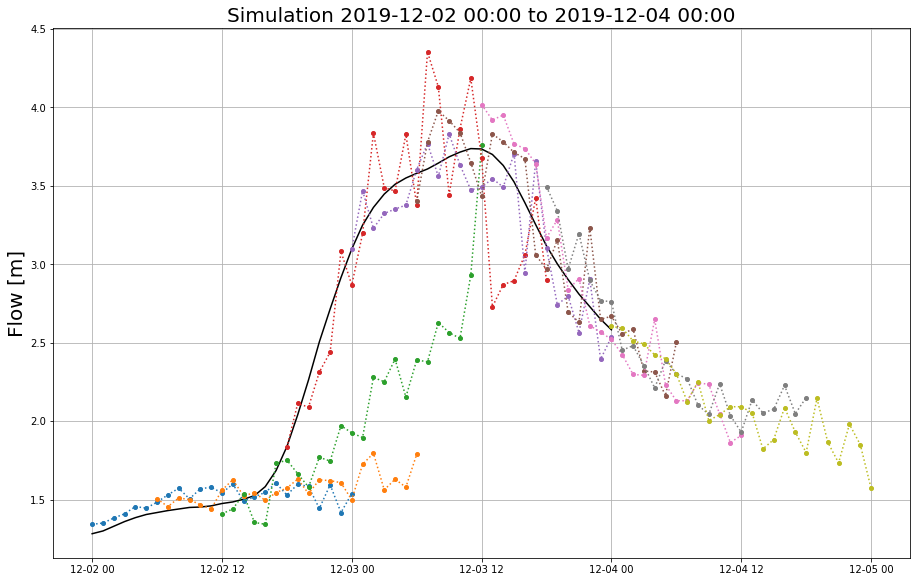

In [ ]:
#@markdown ### Date fields
date_start = '2019-12-02' #@param {type:"date"}
date_end = '2019-12-04' #@param {type:"date"}
#@markdown ### Temporal Interval between each simulation in hours:
step =  6#@param {type:"number"}
#@markdown ###  Plot parameters
#@markdown > You can use Latex syntax to integrate math symbols
ylabel = "Flow [m]" #@param {type:"string"}

folder_plots = os.path.join(folder_output, "plots")
if not os.path.isdir(folder_plots): os.mkdir(folder_plots)
plot_path = os.path.join(folder_plots, "%s_%s.png" %(date_start, date_end))

PlotSimulation(date_start + ' 00:00', date_end + ' 00:00', step,ylabel, plot_path)



##**Step 2.6**: Export the output folder 
Export in a zip file the folder "/content/output_prediction/"

In [ ]:
#@markdown Execute the Step 2.6
shutil.make_archive(folder_ot, 'zip', folder_output)

# Section III

In [ ]:
import datetime
import requests
#@markdown We want to share your experiences. <br>Send a report with suggestions and observation or share to Colab notebook with marco.luppichini@unifi.it. We will happy to answer you.
name = ""#@param {type:"string"}
last_name =  ""#@param {type:"string"}
email = ""#@param {type:"string"}
affiliation = ""#@param {type:"string"}
text = ""#@param {type:"string"}

date = datetime.datetime.today()
payload = {'name': name, 
           'last_name': last_name,
           'email': email,
           'text': text,
           "date" : date,
           "affiliation": affiliation}

res = requests.post("http://131.114.22.25/CleverRiver/dist/php/sendInfo.php", data = payload)
if res.content == '':
  print ("Report sent")
else:
  print ("error")